In [1]:
!pip install opencv-python
!pip install Keras
!pip install tensorflow

In [2]:
import time
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, SGD, Adam
from keras.datasets import mnist
from keras import regularizers
import keras.callbacks as CB
from keras.layers.normalization import BatchNormalization
import pandas as pd
import cv2          # 匯入 OpenCV 影像處理套件， 需要安裝
import glob         # 匯入內建的檔案與資料夾查詢套件
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Reshape

In [3]:
def load_data():
    print ('Loading data...')
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    print(type(X_train))
    X_train = np.concatenate((X_train, X_test), axis=0)
    y_train = np.concatenate((y_train, y_test), axis=0)
    X_test=[]
    y_test=[]
    for label in range(10):
        files = glob.glob( "Training-data/pic_BluePen/"+str(label)+"/*.png" )
        for file in files:
            img = cv2.imread(file)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  #轉灰階
            img = cv2.bitwise_not(img)       # 反白：變成黑底白字
            img = cv2.resize(img, (28, 28))  # 重設大小為 28x28
            X_test.append(img)
            y_test.append(label)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train /= 255
    X_test /= 255

    X_train = np.expand_dims(X_train,axis=3)
    X_test = np.expand_dims(X_test,axis=3)

    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)

    print ('Data loaded.')
    return [X_train, X_test, y_train, y_test]

In [4]:
####################################################################
## You can setup different networks with different regularizers here
#####################################################################
def init_model(rms):
    start_time = time.time()
    print ('Compiling Model ... ')
    model = Sequential()
    model.add(Reshape((784,), input_shape=(None, 28, 28, 1)))
    model.add(Dense(500, kernel_regularizer=regularizers.l2(0.001))) #Use L2
    model.add(BatchNormalization())  #add a BN layer here
    model.add(Activation('relu'))
    #model.add(Dropout(0.4))   #Use dropout
    #model.add(Dense(300, kernel_regularizer=regularizers.l1(0.001))) #Use L1
    model.add(BatchNormalization())  #add a BN layer here
    model.add(Activation('relu'))
    #model.add(Dropout(0.4))
    model.add(Dense(10))
    model.add(BatchNormalization())  #add a BN layer here
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])
    print ('Model compield in {0} seconds'.format(time.time() - start_time))
    return model


In [5]:
def run_network(rms, data=None, model=None, nb_epoch=20, batch_size=256):
    try:
        start_time = time.time()
        if data is None:
            X_train, X_test, y_train, y_test = load_data()
        else:
            X_train, X_test, y_train, y_test = data

        if model is None:
            model = init_model(rms)

        print ('Training model...')

        callbacks= [ CB.EarlyStopping(monitor='val_loss', patience=3, verbose=2) ] ## Use EarlyStop Here

        aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
        width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
        horizontal_flip=True, fill_mode="nearest", validation_split=0.2)        

        history = model.fit_generator(aug.flow(X_train, y_train, batch_size=32),
              steps_per_epoch=len(X_train) // 32, epochs=100)

        print ("Training duration : {0}".format(time.time() - start_time))
        score = model.evaluate(X_test, y_test, batch_size=16)

        print ("Network's test score [loss, accuracy]: {0}".format(score))
        return model, history.history
    except KeyboardInterrupt:
        print (' KeyboardInterrupt')
        return model, history.history


In [6]:
def plot_losses(history_labels):
  for history, label in history_labels:
    plt.figure(1, figsize=(10,10)) 
    plt.subplot(211)   # 2 by 1 array of subplots, and draw the first one 
    plt.plot(history['loss'])  
    #plt.plot(history['val_loss'])  
    plt.title('model loss ' + label)  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper right')  
	
    plt.subplot(212)   # 2 by 1 array of subplots, and draw the second one 
    plt.plot(history['accuracy'])  
    #plt.plot(history['val_accuracy'])  
    plt.title('model accuracy ' + label)  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='lower right')  	
    plt.show() 

In [7]:
def plot_image(image):
    fig = plt.gcf() #design image size
    fig.set_size_inches(2,2) #design image size
    plt.imshow(image, cmap = 'binary') 
    plt.show()


In [8]:
def plot_images_labels_prediction(images, labels, prediction, idx, num=10):
    fig =plt.gcf()
    fig.set_size_inches(10,10)
    if num>25: num = 25
    for i in range(0,num):
        ax = plt.subplot(5,5,i+1) #Generate 5*5 subgraph
        ax.imshow(images[idx], cmap='binary')
        title = "label=" + str(labels[idx])
        if len(prediction)>0:
            title+=",predict=" + str(prediction[idx])
            ax.set_title(title, fontsize=10) #Setting subgraph title and size
            ax.set_xticks([]) #don't show the ticks
            ax.set_yticks([]) #don't show the ticks
            idx+=1
            plt.show()

Loading data...
<class 'numpy.ndarray'>
Data loaded.
Compiling Model ... 
Model compield in 0.2483358383178711 seconds
Training model...
Epoch 1/100


C:\Users\W.R_Chen\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2187/2187 [==============================] - 33s 14ms/step - loss: 1.8226 - accuracy: 0.5469
Epoch 2/100
2187/2187 [==============================] - 29s 13ms/step - loss: 1.1404 - accuracy: 0.7097
Epoch 3/100
2187/2187 [==============================] - 29s 13ms/step - loss: 1.0776 - accuracy: 0.7297
Epoch 4/100
2187/2187 [==============================] - 32s 15ms/step - loss: 1.0521 - accuracy: 0.7387
Epoch 5/100
2187/2187 [==============================] - 29s 13ms/step - loss: 1.0256 - accuracy: 0.74930s - loss: 1.0
Epoch 6/100
2187/2187 [==============================] - 29s 13ms/step - loss: 1.0099 - accuracy: 0.75450s - loss: 1.0099 - accuracy: 
Epoch 7/100
2187/2187 [==============================] - 30s 14ms/step - loss: 0.9979 - accuracy: 0.7532
Epoch 8/100
2187/2187 [==============================] - 29s 13ms/step - loss: 0.9876 - accuracy: 0.7572
Epoch 9/100
2187/2187 [==============================] - 29s 13ms/step - loss: 0.9778 - accuracy: 0.7585
Epoch 10/100
2187/2187 

2187/2187 [==============================] - 29s 13ms/step - loss: 0.8716 - accuracy: 0.7769
Epoch 77/100
2187/2187 [==============================] - 29s 13ms/step - loss: 0.8743 - accuracy: 0.7774
Epoch 78/100
2187/2187 [==============================] - 29s 13ms/step - loss: 0.8686 - accuracy: 0.7795
Epoch 79/100
2187/2187 [==============================] - 29s 13ms/step - loss: 0.8637 - accuracy: 0.7817
Epoch 80/100
2187/2187 [==============================] - 29s 13ms/step - loss: 0.8730 - accuracy: 0.7753
Epoch 81/100
2187/2187 [==============================] - 29s 13ms/step - loss: 0.8764 - accuracy: 0.7737
Epoch 82/100
2187/2187 [==============================] - 29s 13ms/step - loss: 0.8730 - accuracy: 0.7760
Epoch 83/100
2187/2187 [==============================] - ETA: 0s - loss: 0.8746 - accuracy: 0.7763 ETA: 0s - loss: 0.8746 - accu - 28s 13ms/step - loss: 0.8746 - accuracy: 0.7763
Epoch 84/100
2187/2187 [==============================] - 29s 13ms/step - loss: 0.8658 - ac

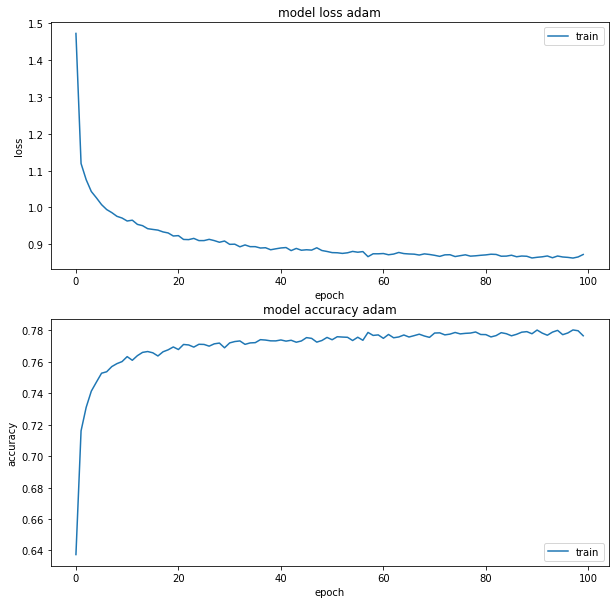

In [9]:
#######################################################
## You can try different optimizers here by setting rms
########################################################

rms = Adam()
model3, hloss3 = run_network(rms)

labels = ['adam']

plot_losses(zip( [hloss3], labels) )